# Find attitude

This notebook is a template for finding the Chandra attitude during anomaly recovery.

In [1]:
import sys

sys.path.insert(0, "/Users/aldcroft/git/ska_sun")
sys.path.insert(0, "/Users/aldcroft/git/ska_helpers")
sys.path.insert(0, "/Users/aldcroft/git/chandra_aca")
sys.path.insert(0, "/Users/aldcroft/git/proseco")

import astropy.units as u
import chandra_aca.plot
import proseco
from cheta import fetch
from cxotime import CxoTime

import find_attitude as fa

%matplotlib inline

In [2]:
def get_att_est(date):
    date = CxoTime(date)
    with fetch.data_source("maude"):
        aoattqt = fetch.Msid("quat_aoattqt", date - 3 * u.s, date)
    att_est = aoattqt.vals[-1]
    return att_est

## Define parameters for this find attitude activity

In [3]:
# Estimated pitch (degrees) from FSS or CSS angles. This is not necessary if a reliable
# estimated attitude (AOATTQT<n>) is available in telemetry.
pitch = None

# Pitch uncertainty in degrees
pitch_err = 1.5  # degrees

# Maximum allowed off_nominal_roll value (degrees) for attitude solutions
off_nominal_roll_max = 2.0  # degrees

In [4]:
# None => use current real-time date. Otherwise set to a specific date.
# date = None
date = "2024:036:20:31:57.917"

In [5]:
# Get the estimated attitude quaternion. If this is not believed to be reliable to
# within ``att_err`` degrees then set to None.
att = get_att_est(date)
# att = None
print(att)

# Attitude quaternion uncertainty in degrees
att_err = 4.0  # degrees

# Matching tolerance (arcsec) for star pair distances. This can be increased if the
# stars are faint and have noisy centroids. If att is known then up to 5.0 arcsec is ok.
tolerance = 3.5  # arcsec

<Quat q1=-0.05303917 q2=-0.05736909 q3=0.92136018 q4=0.38077690>


In [6]:
# Set slots that are tracking good stars
slots = [0, 1, 2, 3, 4, 5, 6, 7]
slots = [0, 3, 5, 6, 7]
stars = fa.get_stars_from_maude(date, slots=slots)
stars.pprint_all()

slot   YAG     ZAG    MAG_ACA
---- ------- -------- -------
   0 1758.39 -1362.11    8.45
   3 2103.84 -2043.00    9.12
   5  706.08  -553.34    9.00
   6 -119.61  1939.14    7.25
   7 2157.80 -2080.83    8.44


In [7]:
constraints = fa.Constraints(
    att=att,  # None if no reliable attitude estimate available
    att_err=att_err,  # Attitude uncertainty (deg)
    pitch=pitch,
    pitch_err=pitch_err,  # Pitch uncertainty degrees
    off_nom_roll_max=2.0,  # Max allowed off-nominal roll (deg) for attitude solution
    date=date,
)

## Find attitude solutions

In [8]:
solutions = fa.find_attitude_solutions(stars, tolerance, constraints)

2024-08-14 09:36:51,660 Using AGASC pairs file /Users/aldcroft/ska/data/find_attitude/distances.h5
2024-08-14 09:36:51,666 Starting get_match_graph
2024-08-14 09:36:51,666 Getting matches from file
2024-08-14 09:36:51,820 Adding edges from 374 matching distance pairs
2024-08-14 09:36:51,821 Added total of 106 nodes
2024-08-14 09:36:51,822 Getting all triangles from match graph
2024-08-14 09:36:51,822 Finding triangles that match stars pattern
2024-08-14 09:36:51,823 Checking clique [638201840, 638727896, 638725736, 638724056, 638720752]
2024-08-14 09:36:51,823 Done with graph matching
2024-08-14 09:36:51,824 Found 1 possible AGASC-ID to star index maps
2024-08-14 09:36:51,824 Finding attitude for {638201840: 3, 638727896: 1, 638725736: 0, 638720752: 4, 638724056: 2} stars
2024-08-14 09:36:52,009 Found attitude <Quat q1=-0.06598975 q2=-0.06480277 q3=0.91930096 q4=0.38253327> with statval 5.491245830885055
2024-08-14 09:36:52,259 Adding solution for {638201840, 638720752, 638724056, 6387

In [9]:
print(f"Found {len(solutions)} solution(s)")

Found 1 solution(s)


In [10]:
# In the summary table below:
# YAG, ZAG, MAG_ACA are from telemetry.
# m_* values are the matched star values.
# dy, dz, dr are the differences between the matched star values and telemetry.
for ii, solution in enumerate(solutions):
    print("-" * 80)
    print(f"Solution {ii}")
    print(f"att = {solution['att_fit'].q}")
    print("-" * 80)
    summary = solution["summary"]
    summary.pprint_all()
    print()

--------------------------------------------------------------------------------
Solution 0
att = [-0.06598975 -0.06480277  0.91930096  0.38253327]
--------------------------------------------------------------------------------
slot   YAG     ZAG    MAG_ACA  m_yag   m_zag   m_mag   dy    dz   dr  m_agasc_id
---- ------- -------- ------- ------- -------- ----- ----- ----- ---- ----------
   0 1758.39 -1362.11    8.45 1758.67 -1361.59  8.45 -0.27 -0.51 0.58  638725736
   3 2103.84 -2043.00    9.12 2104.17 -2044.75  9.24 -0.33  1.76 1.79  638727896
   5  706.08  -553.34    9.00  706.49  -553.52  9.20 -0.41  0.18 0.44  638724056
   6 -119.61  1939.14    7.25 -120.00  1939.53  7.18  0.39 -0.40 0.56  638201840
   7 2157.80 -2080.83    8.44 2157.18 -2079.80  8.51  0.62 -1.03 1.20  638720752



In [11]:
att = solutions[0]["att_fit"]
summary = solutions[0]["summary"]

In [12]:
catalog = proseco.get_aca_catalog(
    att=att,
    date=date,
    n_guide=len(summary),
    include_ids_guide=summary["m_agasc_id"],
    n_fid=0,
    man_angle=0,
    t_ccd_acq=-10,
    t_ccd_guide=-10,
    dither=0,
    detector="hrc-s",
    sim_offset=0,
    focus_offset=0,
    n_acq=0,
)

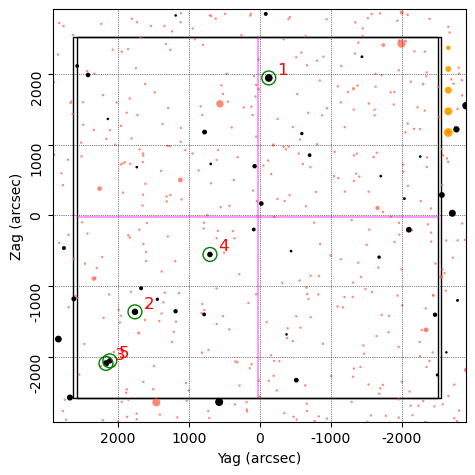

In [13]:
fig = chandra_aca.plot.plot_stars(att, catalog=catalog)